In [1]:
import numpy as np
import numpy.linalg as nl
import scipy.linalg as sl
import scipy.special as sps
import scipy.integrate as si
import scipy.optimize as spo
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import jax.numpy.linalg as jnpl
from jax.config import config
config.update("jax_enable_x64", True)

<h3>TDSE Forward Problem</h3>

In [2]:
# size of spatial domain
L = 10.0

# set number of real space grid points for plotting
nx = 1025
# spatial grid for the purposes of plotting
xvec = np.linspace(-L, L, nx)

# the basis functions used in our Fourier representation
# will be from n = -nF to n = nF
nF = 32
# matrix for converting Fourier basis coefficients to real space values
Fnvec = np.arange(-nF, nF + 1) # Fnvec=-nfb,...,0,...,nfb
Fcnvrtmat = np.exp(1j * np.pi * np.outer(Fnvec, xvec) / L) / np.sqrt(2 * L)

---
**Potential Function**

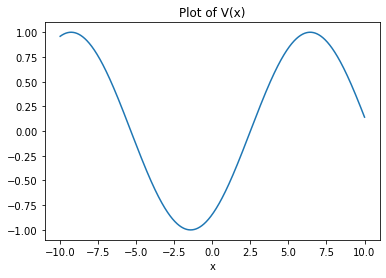

In [232]:
# define potential for generating training data

def v(x):
    # dimensionless quantum harmonic oscillator potential
    # this is a polynomial so it should be exact for Chebyshev
    # return 0.5 * x**2
    # rescaled symmetric double well potential
    # return 0.0025*(x**2 - 25)**2
    # scaled asymmetric double well potential
    # return 0.0003*((x-3)**4 + 10*(x-5)**3)
    # soft coulomb potential
    # return -1 / np.sqrt(x**2 + 0.25)

    # non-polynomial potentials
    return np.sin(0.4 * x - 1)
    # return np.sin((0.5 * x)**2)

# compute true potential on real space grid for plotting
vxvec = v(xvec)

# plot true potential
plt.plot(xvec, vxvec)
plt.title('Plot of V(x)')
plt.xlabel('x')
plt.show()

In [233]:
# transform potential function to Fourier representation
# using quadrature method
# (in tdse-adj-cheb-fft-vs-quad-kbc.ipynb we show that the
# using a quadrature method produces much more accurate results)
Fvtoeprow = []
for thisn in range(2 * nF +1):
    def intgrnd(x):
        return v(x) * np.exp(-1j * np.pi * thisn * x / L) / (2 * L)
    def rintgrnd(x):
        return intgrnd(x).real
    def iintgrnd(x):
        return intgrnd(x).imag
    Fvtoeprow.append(si.quad(rintgrnd, -L, L)[0] + 1j * si.quad(iintgrnd, -L, L)[0])
Fvtoeprow = np.array(Fvtoeprow)
Fvmat = sl.toeplitz(r=Fvtoeprow, c=Fvtoeprow.conj())

print(Fvmat.shape)

(65, 65)


---
**Eigendecomposition of a Fourier Represented Potential**

In [234]:
# construct the kinetic matrix representation of the
# kinetic operator in the Fourier basis
# (this is constant for a given system)
kmat = np.diag(np.arange(-nF, nF + 1)**2 * np.pi**2 / (2 * L**2))

# construct the Hamiltonian matrix representation of the
# Hamiltonian operator in the Fourier basis
Fhmat = kmat + Fvmat

# check if the Hamiltonian matrix is Hermitian
print('hmat Hermitian check (should be close to zero):', nl.norm(Fhmat - Fhmat.T.conj()), sep='\n')

# eigen-decomposition of the Hamiltonian matrix
Fspc, Fstts = nl.eigh(Fhmat)

# check if the eigendecomposition diagonalizes the
# Hamiltonian matrix
# if this is close to zero then
# hmat = states @ np.diag(spec) @ np.conj(states).T
print('Check if hmat is diagonalized (should be close to zero):', nl.norm(Fhmat @ Fstts - Fstts @ np.diag(Fspc)), sep='\n')

# check if the eigenstates are unitary
print('Unitary stts check (should be close to zero):', nl.norm(Fstts @ Fstts.T.conj() - np.eye(2 * nF + 1)), sep='\n')

hmat Hermitian check (should be close to zero):
0.0
Check if hmat is diagonalized (should be close to zero):
2.1910809598848296e-13
Unitary stts check (should be close to zero):
1.143916595023259e-14


[-0.80513559 -0.42629761 -0.07043128  0.25950176  0.55804545  0.74604811]


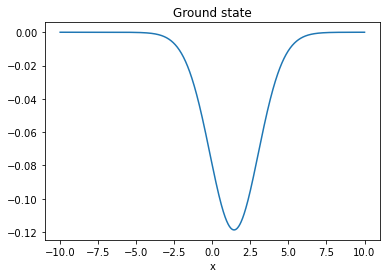

Quick check of normalization (should be close to 1):
1.0000000000024576
Check of normalization (should be close to 1):
0.9999999999999991


In [235]:
# find indices that sort eigenvalues
ordering = np.argsort(Fspc)

# print the first few eigenvalues
print(Fspc[ordering[:6]])

# pick out and plot ground state
groundstate = ordering[0]
wavefn = Fstts[:,groundstate] @ Fcnvrtmat
plt.plot(xvec, np.real(wavefn))
plt.title('Ground state')
plt.xlabel('x')
plt.show()

# quick and dirty check of normalization
print('Quick check of normalization (should be close to 1):', np.sum(np.abs(wavefn)**2 * (xvec[1]-xvec[0])), sep='\n')

# this should be a more accurate check of the ground state
# wave functions' normalization
print('Check of normalization (should be close to 1):', si.trapezoid(np.abs(wavefn)**2, xvec), sep='\n')

---
<h3>Foward Propagation</h3>

In [236]:
# solve the forward problem in the Fourier
# representation and store the trajectory
# in Famat

# set the size of a time step
dt = 1e-2

# set the number of time steps to take starting from
# the initial state (a single trajectory should be
# nts + 1 states, this includes the initial state)
ntsteps = 100  # 600  # 400  # 200


---
**Initial Wave Function and its Fourier Representation**

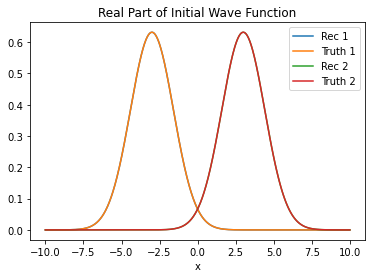

L2 Error psi0_1: 4.072507283500841e-06
L-infinity Error psi0_1: 1.8301527573114097e-06
L2 Error psi0_2: 4.072507283500477e-06
L-infinity Error psi0_2: 1.8301527573114097e-06


In [237]:
# define initial state(s) and transform to Fourier basis

ainitvec = []

def psi0_1(x):
    # return 1.0 + np.tanh((1 - x**2)/0.5)  # rounded box function
    # return np.piecewise(x, [x < -1, (x >= -1) & (x <= 1), x > 1], [0, lambda x: (1 - np.abs(x)), 0])  # triangular pulse
    # return np.piecewise(x, [x < -1, (x >= -1) & (x <= 1), x > 1], [0, lambda x: (1 - x**2), 0])  # parabolic pulse
    # return (np.cosh(x))**(-2)  # hyperbolic secant squared
    # return np.exp(-np.abs(x))  # Laplace
    # HSB's "super simple initial condition"
    # return np.exp(-x**2) * (2.0 / np.pi)**0.25  # Gaussian with L^2 norm = 1
    #
    return np.exp(-(x + 3)**2 / 4) * (2.0 / np.pi)**0.25
    # return np.exp(-(x + 7)**2 / 0.2) * (2.0 / np.pi)**0.25

# WHEN USING HSB'S GAUSSIAN WITH L^2 NORM = 1
# normpsi0_1_fn = psi0_1
# WHEN NOT USING HSB'S GAUSSIAN WITH L^2 NORM = 1
# compute psi0 normalization term
psi0_1_probintgrnd = lambda x: np.abs(psi0_1(x))**2
psi0_1_normtrm = np.sqrt(si.quad(psi0_1_probintgrnd, -L, L)[0])
# define normalized psi function to be used by
# a scipy.integrate methods
def normpsi0_1_fn(x):
    return psi0_1(x)/psi0_1_normtrm

# compute the Fourier basis representation of the
# normalized psi0 function using quadrature method
normpsi0_1_quad = np.zeros(nF + 1, dtype=np.complex128)
for thisn in range (nF + 1):
    def intgrnd(x):
        return normpsi0_1_fn(x) * np.exp(-1j * np.pi * thisn * x / L) / np.sqrt(2 * L)
    def rintgrnd(x):
        return intgrnd(x).real
    def iintgrnd(x):
        return intgrnd(x).imag
    normpsi0_1_quad[thisn] = si.quad(rintgrnd, -L, L)[0] + 1j*si.quad(iintgrnd, -L, L)[0]

ainit_1 = np.concatenate([np.conjugate(np.flipud(normpsi0_1_quad[1:])), normpsi0_1_quad])

ainitvec.append(ainit_1)

def psi0_2(x):
    # return 1.0 + np.tanh((1 - x**2)/0.5)  # rounded box function
    # return np.piecewise(x, [x < -1, (x >= -1) & (x <= 1), x > 1], [0, lambda x: (1 - np.abs(x)), 0])  # triangular pulse
    # return np.piecewise(x, [x < -1, (x >= -1) & (x <= 1), x > 1], [0, lambda x: (1 - x**2), 0])  # parabolic pulse
    # return (np.cosh(x))**(-2)  # hyperbolic secant squared
    # return np.exp(-np.abs(x))  # Laplace
    # HSB's "super simple initial condition"
    # return np.exp(-x**2) * (2.0 / np.pi)**0.25  # Gaussian with L^2 norm = 1
    #
    # return np.exp(-(x - 7)**2 / 0.2) * (2.0 / np.pi)**0.25
    return np.exp(-(x - 3)**2 / 4) * (2.0 / np.pi)**0.25

# WHEN USING HSB'S GAUSSIAN WITH L^2 NORM = 1
# normpsi0_2_fn = psi0_2
# WHEN NOT USING HSB'S GAUSSIAN WITH L^2 NORM = 1
# compute psi0 normalization term
psi0_2_probintgrnd = lambda x: np.abs(psi0_2(x))**2
psi0_2_normtrm = np.sqrt(si.quad(psi0_2_probintgrnd, -L, L)[0])
# define normalized psi function to be used by
# a scipy.integrate methods
def normpsi0_2_fn(x):
    return psi0_2(x)/psi0_2_normtrm

# compute the Fourier basis representation of the
# normalized psi0 function using quadrature method
normpsi0_2_quad = np.zeros(nF + 1, dtype=np.complex128)
for thisn in range (nF + 1):
    def intgrnd(x):
        return normpsi0_2_fn(x) * np.exp(-1j * np.pi * thisn * x / L) / np.sqrt(2 * L)
    def rintgrnd(x):
        return intgrnd(x).real
    def iintgrnd(x):
        return intgrnd(x).imag
    normpsi0_2_quad[thisn] = si.quad(rintgrnd, -L, L)[0] + 1j*si.quad(iintgrnd, -L, L)[0]

ainit_2 = np.concatenate([np.conjugate(np.flipud(normpsi0_2_quad[1:])), normpsi0_2_quad])

ainitvec.append(ainit_2)

normpsi0_1_vecrec = ainitvec[0] @ Fcnvrtmat
normpsi0_1_vec = normpsi0_1_fn(xvec)

normpsi0_2_vecrec = ainitvec[1] @ Fcnvrtmat
normpsi0_2_vec = normpsi0_2_fn(xvec)

# plot the real part of the normalized psi0
plt.plot(xvec, normpsi0_1_vecrec.real, label="Rec 1")
plt.plot(xvec, normpsi0_1_vec.real, label="Truth 1")
plt.plot(xvec, normpsi0_2_vecrec.real, label="Rec 2")
plt.plot(xvec, normpsi0_2_vec.real, label="Truth 2")
plt.title('Real Part of Initial Wave Function')
plt.xlabel('x')
plt.legend()
plt.show()

print('L2 Error psi0_1:', nl.norm(normpsi0_1_vecrec - normpsi0_1_vec))
print('L-infinity Error psi0_1:', np.max(np.abs(normpsi0_1_vecrec - normpsi0_1_vec)))

print('L2 Error psi0_2:', nl.norm(normpsi0_2_vecrec - normpsi0_2_vec))
print('L-infinity Error psi0_2:', np.max(np.abs(normpsi0_2_vecrec - normpsi0_2_vec)))

---
**Forward Propagation of ainit using the Potential in Fourier Representation**

In [238]:
# compute the propagator matrix reusing the
# spectrum and states from the eigendecomposition
# of Hamiltonian matrix computed above
Fpropa = Fstts @ np.diag(np.exp(-1j * Fspc * dt)) @ Fstts.conj().T

Famatvec = []
# propagate the system starting from the initial "a" state
for thisainit in ainitvec:
    tempFamat = np.zeros((ntsteps + 1, 2 * nF + 1), dtype=np.complex128)
    tempFamat[0] = thisainit.copy()
    for i in range(ntsteps):
        tempFamat[i + 1] = Fpropa @ tempFamat[i]
    Famatvec.append(tempFamat)

# compute the wave function in space from each "a" vector
# do it all at once using matrix multiplication!
Fpsimat_1 = Famatvec[0] @ Fcnvrtmat
Fpsimat_2 = Famatvec[1] @ Fcnvrtmat

print('Done propagating.')

Done propagating.


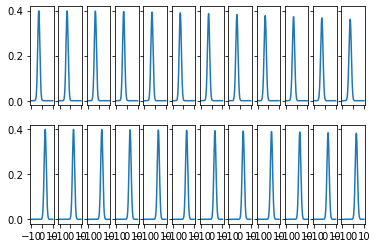

In [239]:
numsnapshots = 12

fig, axs = plt.subplots(nrows=2, ncols=numsnapshots, sharex='all', sharey='all')

plottstep = ntsteps // numsnapshots

for i in range(2):
    for j in range(numsnapshots):
        axs[i, j].plot(xvec, np.abs((Famatvec[i] @ Fcnvrtmat)[plottstep * j])**2)

plt.show()

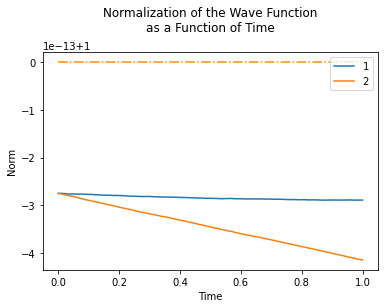

Average Norm of Trajectory Fpsimatnormvec_1 (should be close to 1):
0.9999999999997162
Average Norm of Trajectory Fpsimatnormvec_2 (should be close to 1):
0.999999999999655


In [240]:
# check if the wave function of each time step
# is normalized to 1
# this should produce a graph with a line that is almost
# completely horizontal at 1
Fpsimatnormvec_1 = si.trapezoid(np.abs(Fpsimat_1)**2, xvec, axis=1)
plt.plot(np.arange(ntsteps + 1) * dt, Fpsimatnormvec_1, label='1')
Fpsimatnormvec_2 = si.trapezoid(np.abs(Fpsimat_2)**2, xvec, axis=1)
plt.plot(np.arange(ntsteps + 1) * dt, Fpsimatnormvec_2, label='2')
plt.hlines(1 , 0, ntsteps * dt, linestyles='-.', colors='darkorange', label='_')
plt.title('Normalization of the Wave Function\nas a Function of Time\n')
plt.xlabel('Time')
plt.ylabel('Norm')
plt.legend()
plt.show()

# norm difference of wave function normalization check,
# this should be close to 1
print('Average Norm of Trajectory Fpsimatnormvec_1 (should be close to 1):', Fpsimatnormvec_1.sum() / (ntsteps + 1), sep='\n')
print('Average Norm of Trajectory Fpsimatnormvec_2 (should be close to 1):', Fpsimatnormvec_2.sum() / (ntsteps + 1), sep='\n')

---
<h3>Chebyshev Representation</h3>

In [241]:
# set the number of Chebyshev coefficients
# for the soft columb potential odd values work best
nc = 11  # 31

[ 3.34190042e-01 -7.13667248e-02  6.12806539e-01 -4.64845279e-01
 -4.73123902e-01  1.42733450e-01  8.26115404e-02 -1.63993309e-02
 -6.78001000e-03  1.01427855e-03  3.28000232e-04 -4.06164378e-05]


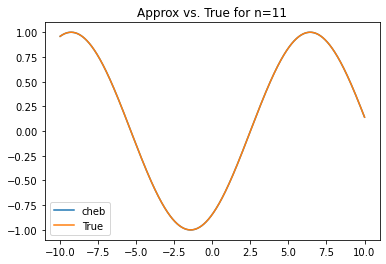

L2 Error (should be close to zero):
0.00024395423364296994
L-infinity Error (should be close to zero):
1.2156706042154575e-05


In [242]:
# to test our Chebyshev representation let's represent
# the potential function, v(x), using Chebyshev polynomials
# then reconstruct it in real space and compare the sampled
# function to the reconstruction
# for the simple harmonic potential this should be
# exact because v(x) **is** a polynomial

def theta(k):
    return (k - 0.5) * np.pi / (nc + 1)

def g(k):
    # cos(\theta) ranges from [-1, 1] which is the domain
    # of the Chebyshev interpolation function so we need to
    # modify v()'s so when it is given x \in [-1, 1], it
    # actually spans the domain [-L, L]
    # to do that, we multiply by np.cos(theta(k)) by L
    return v(L * np.cos(theta(k)))

kvec = np.arange(1, nc + 2)
cnvec = np.arange(0, nc + 1)

cweights = np.ones(nc + 1)
cweights[0] = 0.5

# compute Chebyshev coefficients
cvec = 2 / (nc + 1) * np.sum(g(kvec) * np.cos(cnvec[..., np.newaxis] * theta(kvec)), axis=1)
cvec = cweights * cvec
print(cvec)

ctoxmat = sps.eval_chebyt(np.expand_dims(cnvec, 0), np.expand_dims(xvec / L, 1))
vrec = ctoxmat @ cvec

# plot reconstruction vs truth
plt.plot(xvec, vrec, label='cheb')
plt.plot(xvec, vxvec, label='True')
plt.title(f'Approx vs. True for n={nc}')
plt.legend()
plt.show()

# vec L2 error
print('L2 Error (should be close to zero):', nl.norm(v(xvec) - vrec), sep='\n')
# L-infinity error
print('L-infinity Error (should be close to zero):', np.max(np.abs(v(xvec) - vrec)), sep='\n')

---
**Form the Potential Matrix from the Chebyshev Representation**

In [243]:
# to test our Chebyshev representation let's construct
# the potential matrix, vmat, using Chebyshev polynomials
# via quadrature method then check the result against
# the potential matrix formed directly in the Fourier
# representation

# this function returns the chebyshev approximation of
# the potential at some spatial point x, this is needed
# for transforming the Chebyshev coefficients to the
# Fourier representation by quadrature method
# def vchebaprx(x):
    # don't forget the interval of the argument x is [-L, L]
    # but for the chebyshev representation it needs to be
    # [-1, 1] so we need to divide x by L
    # return sps.eval_chebyt(np.expand_dims(cnvec, 0), x / L) @ cvec

# compute the Fourier representation of the Chebyshev
# coefficients of the true potential
# cvrowquad = np.zeros(2 * nF + 1, dtype=np.complex128)
# for thisn in range(2 * nF + 1):
#     def intgrnd(x):
#         return vchebaprx(x) * np.exp(-1j * np.pi * thisn * x / L) / (2 * L)
#     def rintgrnd(x):
#         return intgrnd(x).real
#     def iintgrnd(x):
#         return intgrnd(x).imag
#     cvrowquad[thisn] = si.quad(rintgrnd, -L, L)[0] + 1j * si.quad(iintgrnd, -L, L)[0]

# creates matrix that can be used to transform
# the Chebyshev coefficients to the Fourier representation
# chebtoF = np.zeros((2 * nF + 1, nc + 1), dtype=np.complex128)
chebtoF = []
for thiscn in range(nc + 1):
    temptoeprow = []
    for thisn in range(2 * nF + 1):
        def intgrnd(x):
            # tvec = lambda x: sps.eval_chebyt(np.expand_dims(thiscn, 0), x / L)
            # return tvec(x) * np.exp(-1j * np.pi * thisn * x / L) / (2 * L)
            return sps.eval_chebyt(thiscn, x / L) * np.exp(-1j * np.pi * thisn * x / L) / (2 * L)
        def rintgrnd(x):
            return intgrnd(x).real
        def iintgrnd(x):
            return intgrnd(x).imag

        # chebtoF[thisn, thiscn] = si.quad(rintgrnd, -L, L)[0] + 1j * si.quad(iintgrnd, -L, L)[0]
        temptoeprow.append(si.quad(rintgrnd, -L, L)[0] + 1j * si.quad(iintgrnd, -L, L)[0])
    chebtoF.append(sl.toeplitz(r=temptoeprow, c=np.conj(temptoeprow)))
    # chebtoF.append(temptoeprow)

chebtoF = np.array(chebtoF).T
print('Shape chebtoF:', chebtoF.shape)

# check how much the Fourier representation coefficients
# constructed from the Chebyshev representation differ from
# the true Fourier coefficients
# (i.e., compare the potential in the Fourier representation
# to the potential reconstructed from the Chebyshev representation)
# print('L2 Norm Error (should be close to 0):', nl.norm(Fvtoeprow - chebtoF @ cvec))  # 2.319575846403117e-13
print(sl.toeplitz(r=Fvtoeprow, c=np.conj(Fvtoeprow)).shape)
print((chebtoF @ cvec).shape)
print('L2 Norm Error (should be close to 0):', nl.norm(sl.toeplitz(r=Fvtoeprow, c=np.conj(Fvtoeprow)) - chebtoF @ cvec))  # 1.2698568848776662e-12
# print('L-infinity Error (should be close to 0):', np.max(np.abs(Fvtoeprow - chebtoF @ cvec)))  # 1.4527419384605627e-13
print('L-infinity Error (should be close to 0):', np.max(np.abs(sl.toeplitz(r=Fvtoeprow, c=np.conj(Fvtoeprow)) - chebtoF @ cvec)))  # 1.452737601671089e-13

Shape chebtoF: (65, 65, 12)
(65, 65)
(65, 65)
L2 Norm Error (should be close to 0): 5.665383265681855
L-infinity Error (should be close to 0): 0.4190933241631666


---
**Eigendecomposition of a Chebyshev Represented Potential**

In [244]:
# to test our Chebyshev representation let's compare
# the Hamiltonian matrix and its eigendecomposition
# constructed from the potential matrix reconstructed
# from the Chebyshev coefficients of the potential
# to the same features constructed directly in the
# Fourier representation

# make the potential matrix from the Chebyshev coefficents
# cvmat = sl.toeplitz(r=chebtoF @ cvec, c=np.conj(chebtoF @ cvec))
cvmat = chebtoF @ cvec

# construct the Hamiltonian matrix representation of the
# Hamiltonian operator in the Fourier basis
chmat = kmat + cvmat

# check if the Hamiltonian matrix is Hermitian
print('hmat Hermitian check (should be close to zero):', nl.norm(chmat - chmat.T.conj()), sep='\n')

# eigendecomposition of the Hamiltonian matrix
cspc, cstts = nl.eigh(chmat)

# check if the eigendecomposition diagonalizes the
# Hamiltonian matrix
# if this is close to zero then
# hmat = states @ np.diag(spec) @ np.conj(states).T
print('Check if hmat is diagonalized (should be close to zero):', nl.norm(chmat @ cstts - cstts @ np.diag(cspc)), sep='\n')

# check if the eigenstates are unitary
print('Unitary stts check (should be close to zero):', nl.norm(cstts @ cstts.T.conj() - np.eye(2 * nF + 1)), sep='\n')

# results for the original way
# hmat Hermitian check (should be close to zero):
# 0.0
# Check if hmat is diagonalized (should be close to zero):
# 3.264297626570781e-13
# Unitary stts check (should be close to zero):
# 1.1878611598105484e-14

hmat Hermitian check (should be close to zero):
0.0
Check if hmat is diagonalized (should be close to zero):
2.136147670802644e-13
Unitary stts check (should be close to zero):
1.2283652293521849e-14


In [245]:
print('L2 Error of the Hamiltonian matrix (should be close to 0):', nl.norm(cvmat - Fvmat), sep='\n')
print('L2 Error of spectrum (should be close to 0):', nl.norm(cspc - Fspc), sep='\n')
print('L2 Error of states (should be close to 0):', nl.norm(cstts - Fstts), sep='\n')

# results for the original way
# L2 Error of the Hamiltonian matrix (should be close to 0):
# 1.44838302671362e-12
# L2 Error of spectrum (should be close to 0):
# 5.43553446497394e-13
# L2 Error of states (should be close to 0):
# 7.48331477354788

L2 Error of the Hamiltonian matrix (should be close to 0):
5.665383265681855
L2 Error of spectrum (should be close to 0):
3.0693095958842102e-06
L2 Error of states (should be close to 0):
11.258725816170891


---
**Forward Propagation of ainit using the Potential in the Cheybshev Representation**

In [246]:
# propagate the system using the Chebyshev
# representation of the true potential and compare
# if chebyshev propagation agrees with Fourier
# propagation

# compute the propagator matrix reusing the
# spectrum and states from the eigendecomposition
# of Hamiltonian matrix computed above
# cspc, cstts
cpropa = cstts @ np.diag(np.exp(-1j * cspc * dt)) @ cstts.conj().T

camatvec = []
# propagate the system starting from the initial "a" state
for thisainit in ainitvec:
    tempcamat = np.zeros((ntsteps + 1, 2 * nF + 1), dtype=np.complex128)
    tempcamat[0] = thisainit.copy()
    for i in range(ntsteps):
        tempcamat[i + 1] = cpropa @ tempcamat[i]
    camatvec.append(tempcamat)

# compute the wave function in space from each "a" vector
# do it all at once using matrix multiplication!
cpsimat_1 = camatvec[0] @ Fcnvrtmat
cpsimat_2 = camatvec[1] @ Fcnvrtmat

print('Done propagating.')

Done propagating.


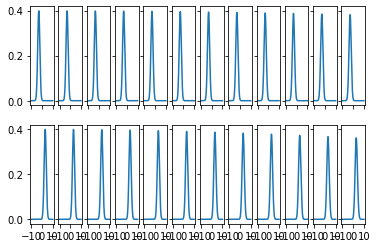

In [247]:
fig, axs = plt.subplots(nrows=2, ncols=numsnapshots, sharex='all', sharey='all')

plottstep = ntsteps // numsnapshots

for i in range(2):
    for j in range(numsnapshots):
        axs[i, j].plot(xvec, np.abs((camatvec[i] @ Fcnvrtmat)[plottstep * j])**2)

plt.show()

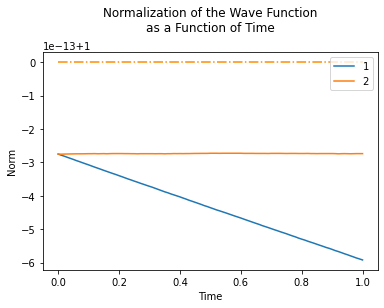

Average Norm of Trajectory 1 (should be close to 1):
0.9999999999995652
Average Norm of Trajectory 2 (should be close to 1):
0.9999999999997267


In [248]:
# check if the wave function of each time step
# is normalized to 1
# this should produce a graph with a line that is almost
# completely horizontal at 1
cpsimatnormvec_1 = si.trapezoid(np.abs(cpsimat_1) ** 2, xvec, axis=1)
plt.plot(np.arange(ntsteps + 1) * dt, cpsimatnormvec_1, label='1')
cpsimatnormvec_2 = si.trapezoid(np.abs(cpsimat_2) ** 2, xvec, axis=1)
plt.plot(np.arange(ntsteps + 1) * dt, cpsimatnormvec_2, label='2')
plt.hlines(1 , 0, ntsteps * dt, linestyles='-.', colors='darkorange', label='_')
plt.title('Normalization of the Wave Function\nas a Function of Time\n')
plt.xlabel('Time')
plt.ylabel('Norm')
plt.legend()
plt.show()

# norm difference of wave function normalization check,
# this should be close to 1
print('Average Norm of Trajectory 1 (should be close to 1):', cpsimatnormvec_1.sum() / (ntsteps + 1), sep='\n')
print('Average Norm of Trajectory 2 (should be close to 1):', cpsimatnormvec_2.sum() / (ntsteps + 1), sep='\n')

L2 Error Trajectory 1 (should be close to 0):
38.19667675323399
L-infinity Error Trajectory 1 (should be close to 0):
0.5811061283492793
L2 Error Trajectory 2 (should be close to 0):
38.19634207723405
L-infinity Error Trajectory 2 (should be close to 0):
0.5810985552175582


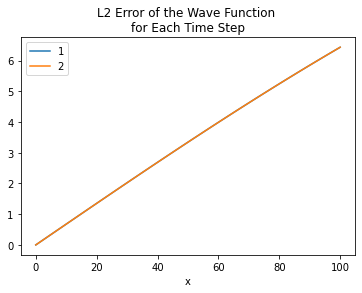

In [249]:
print('L2 Error Trajectory 1 (should be close to 0):', nl.norm(cpsimat_1 - Fpsimat_1), sep='\n')
print('L-infinity Error Trajectory 1 (should be close to 0):', np.max(np.abs(cpsimat_1 - Fpsimat_1)), sep='\n')
print('L2 Error Trajectory 2 (should be close to 0):', nl.norm(cpsimat_2 - Fpsimat_2), sep='\n')
print('L-infinity Error Trajectory 2 (should be close to 0):', np.max(np.abs(cpsimat_2 - Fpsimat_2)), sep='\n')

plt.plot(nl.norm(cpsimat_1 - Fpsimat_1, axis=1), label='1')
plt.plot(nl.norm(cpsimat_2 - Fpsimat_2, axis=1), label='2')
plt.title('L2 Error of the Wave Function \nfor Each Time Step')
plt.xlabel('x')
plt.legend()
plt.show()

---
<h3>Inverse Problem - Adjoint Method</h3>

In [250]:
# this code is used to make a toeplitz matrix from the
# Fourier representation
# flattoepvec = jnp.concatenate([jnp.flipud(cvrow.conj()), cvrow[1:]])

numtoepelms = 2 * nF + 1
a = (-1) * np.arange(0, numtoepelms).reshape(numtoepelms, 1)
b = [np.arange(numtoepelms - 1, 2 * numtoepelms -1)]
toepindxmat = jnp.array(a + b)
print(toepindxmat.shape)

(65, 65)


In [251]:
# convert python list to JAX object
jaxFamatvec = jnp.stack(Famatvec)
print(jaxFamatvec.shape)

# convert the NumPy chebtoF matrix to a JAX object
jaxchebtoF = jnp.array(chebtoF)
print(jaxchebtoF.shape)

(2, 101, 65)
(65, 65, 12)


In [252]:
def cobjfn(cffs):
    # construct the vmat from Chebyshev coefficients
    # vmat = ctovmat(cffs)
    # cvrow = jaxchebtoF @ cffs
    # flattoepvec = jnp.concatenate([jnp.flipud(cvrow.conj()), cvrow[1:]])
    # vhatmat = jnp.array(flattoepvec[toepindxmat])
    vhatmat = jaxchebtoF @ cffs
    # print('L2 Error vmat (should be close to 0):', jnpl.norm(vmat - cvmat), sep='\n')

    # construct the Hamiltonian matrix
    hhatmat = kmat + vhatmat
    # print('L2 Error hmat (should be close to 0):', jnpl.norm(hmat - chmat), sep='\n')

    # eigendecomposition of the Hamiltonian matrix
    spchat, sttshat = jnpl.eigh(hhatmat)
    # print('L2 Error spc (should be close to 0):', jnpl.norm(spc - cspc), sep='\n')
    # print('L2 Error stts (should be close to 0):', jnpl.norm(stts - cstts), sep='\n')

    # compute the propagator matrix using the
    # result of the eigendecomposition
    propahatmat = sttshat @ jnp.diag(jnp.exp(-1j * spchat * dt)) @ sttshat.conj().T
    # print('L2 Error propamat (should be close to 0):', jnpl.norm(propamat - cpropa), sep='\n')

    ahatmatvec = []
    # propagate the system starting from the initial "a" state
    for thisainit in ainitvec:
        tempamat = [thisainit.copy()]
        for i in range(ntsteps):
            tempamat.append(propahatmat @ tempamat[i])
        # make python list a jax object
        ahatmatvec.append(jnp.stack(tempamat))
    # make python list a jax object
    ahatmatvec = jnp.stack(ahatmatvec)

    # compute the sum of objective functions in one line
    residue = ahatmatvec - jaxFamatvec
    objective = jnp.sum(0.5 * jnp.real(jnp.sum(jnp.conj(residue) * residue, axis=1)))

    return objective

In [253]:
# check if the objective function gives zero when the
# chebyshev coefficients of the true potential are fed in
# this should produce a result which is very close to zero
print('Objective for True Chebyshev Coefficients (should be close to 0):', cobjfn(cvec), sep='\n')

Objective for True Chebyshev Coefficients (should be close to 0):
28.49557288137052


In [254]:
jitcobjfn = jax.jit(cobjfn)

In [255]:
jitcobjfn(cvec)

DeviceArray(28.49557288, dtype=float64)

In [256]:
jaxgradcobjfn = jax.jit(jax.grad(cobjfn))

In [257]:
# check if the JAX grad of the objective function works
# this should give all zeros (or close to that)
print('jaxgradcobjfn(cvec) (should be close to 0):', jaxgradcobjfn(cvec), sep='\n')

jaxgradcobjfn(cvec) (should be close to 0):
[-2.20051169e-04  1.76827206e+01 -3.19512404e-02 -4.43192293e+01
  1.21376966e-01  5.02030801e+01 -2.33844896e-01 -3.55802369e+01
  2.98585345e-01  1.11530358e+01 -2.43945375e-01  9.97337219e+00]


---
**Initialize with true coefficients perturbed by random normally distributed noise**

In [258]:
# easy test case: initialize theta with true theta perturbed with
# random normally distributed noise with a small variance.
# This should be easy for the optimizer to converge to a good minimum

seed = 1234  # set to None for random initialization
cfftrub = cvec.copy()
cfftrub += 0.25 * np.random.default_rng(seed).normal(size=cvec.shape)
# cfftrub += 5.0 * np.random.default_rng(seed).normal(size=cvec.shape)

In [259]:
# print(cobjfn(cfftrub))
# print(gradcobjfn(cfftrub))

In [260]:
restrubjaxgrad = spo.minimize(jitcobjfn, cfftrub, jac=jaxgradcobjfn, tol=1e-12, options={'maxiter': 200, 'disp': True, 'gtol': 1e-15}).x

         Current function value: 0.000000
         Iterations: 103
         Function evaluations: 176
         Gradient evaluations: 164


In [261]:
def sqrerrorfn(x, cffs):
    return (sps.eval_chebyt(cnvec, x / L) @ cffs - v(x))**2

print('Continuous L2 Error of Potential using Quadrature Method:', np.sqrt(si.quad(sqrerrorfn, -L, L, args=(cvec)))[0], sep='\n')

Continuous L2 Error of Potential using Quadrature Method:
3.406051033103937e-05


Objective of the Learned Coefficients:
2.2011845813319967e-13
Vec L2 Norm of Gradient of the Learned Coefficients:
2.7729704086487705e-12
Continuous L2 Error of Potential using Quadrature Method:
3.199046805851998


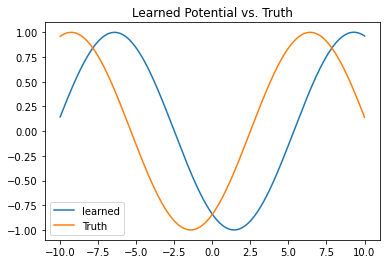

In [262]:
# print('Chebyshev Coefficients of the True Potential:', cvec, sep='\n')
# print('', 'Chebyshev Coefficients of the Learned Potential:', restrub, sep='\n')

print('Objective of the Learned Coefficients:', cobjfn(restrubjaxgrad), sep='\n')
print('Vec L2 Norm of Gradient of the Learned Coefficients:', nl.norm(jaxgradcobjfn(restrubjaxgrad)), sep='\n')

print('Continuous L2 Error of Potential using Quadrature Method:', np.sqrt(si.quad(sqrerrorfn, -L, L, args=(restrubjaxgrad)))[0], sep='\n')

# print('', 'Gradient of the Learned Coefficients:', gradcobjfn(restrub), sep='\n')

# print('', 'L2 Error of the Initialized Chebyshev Coefficients:', nl.norm(cvec - cfftrub), sep='\n')
# print('', 'L2 Error of the Learned Chebyshev Coefficients:', nl.norm(cvec - restrub), sep='\n')
# print('', 'L-infinity Error of the Initialized Chebyshev Coefficients:', np.max(np.abs(cvec - cfftrub)), sep='\n')
# print('', 'L-infinity Error of the Learned Chebyshev Coefficients:', np.max(np.abs(cvec - restrub)), sep='\n')

# plot learned vs true
# plt.plot(xvec, ctoxmat @ cfftrub, label='initial')
plt.plot(xvec, ctoxmat @ restrubjaxgrad, label='learned')
plt.plot(xvec, vxvec, label='Truth')
plt.title('Learned Potential vs. Truth')
plt.legend()
plt.show()

---

In [263]:
seed = 1234  # set to None for random initialization
cffform = np.random.default_rng(seed).uniform(low=-5.0, high=5.0, size=cvec.shape)

In [264]:
resform = spo.minimize(jitcobjfn, cffform, jac=jaxgradcobjfn, tol=1e-15, options={'maxiter': 1000, 'disp': True, 'gtol': 1e-14}).x
# used 'maxiter': 200 and nc = 1 for harmonic potential and sin(x)

         Current function value: 0.000000
         Iterations: 121
         Function evaluations: 240
         Gradient evaluations: 226


Objective of the Learned Coefficients:
2.2011845334502423e-13
Vec L2 Norm of Gradient of the Learned Coefficients:
4.691120100557708e-11
Continuous L2 Error of Potential using Quadrature Method:
3.1990468124257996


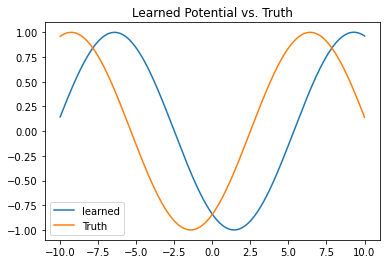

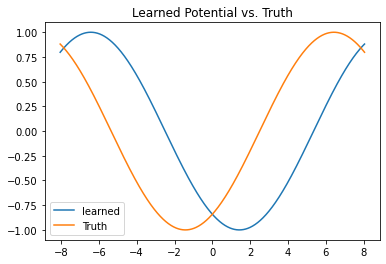

In [265]:
# print('Chebyshev Coefficients of the True Potential:', cvec, sep='\n')
# print('', 'Chebyshev Coefficients of the Learned Potential:', resform, sep='\n')

print('Objective of the Learned Coefficients:', cobjfn(resform), sep='\n')
print('Vec L2 Norm of Gradient of the Learned Coefficients:', nl.norm(jaxgradcobjfn(resform)), sep='\n')

print('Continuous L2 Error of Potential using Quadrature Method:', np.sqrt(si.quad(sqrerrorfn, -L, L, args=(resform)))[0], sep='\n')

# print('', 'Gradient of the Learned Coefficients:', gradcobjfn(resform), sep='\n')

# print('', 'L2 Error of the Initialized Chebyshev Coefficients:', nl.norm(cvec - cffform), sep='\n')
# print('', 'L2 Error of the Learned Chebyshev Coefficients:', nl.norm(cvec - resform), sep='\n')
# print('', 'L-infinity Error of the Initialized Chebyshev Coefficients:', np.max(np.abs(cvec - cffform)), sep='\n')
# print('', 'L-infinity Error of the Learned Chebyshev Coefficients:', np.max(np.abs(cvec - resform)), sep='\n')

# plot learned vs true
# plt.plot(xvec, ctoxmat @ cffform, label='initial')
plt.plot(xvec, ctoxmat @ resform, label='learned')
plt.plot(xvec, vxvec, label='Truth')
# plt.xlim((-5, 5))
# plt.ylim((0, 10))
plt.title('Learned Potential vs. Truth')
plt.legend()
plt.show()

# plot learned vs true
plt.plot(xvec[100:-100], (ctoxmat @ resform)[100:-100], label='learned')
plt.plot(xvec[100:-100], vxvec[100:-100], label='Truth')
# plt.xlim((-5, 5))
# plt.ylim((0, 10))
plt.title('Learned Potential vs. Truth')
plt.legend()
plt.show()

---

In [266]:
def adjhelper(cffs):
    # construct the vmat from Chebyshev coefficients
    # vmat = ctovmat(cffs)
    # cvrow = jaxchebtoF @ cffs
    # flattoepvec = jnp.concatenate([jnp.flipud(cvrow.conj()), cvrow[1:]])
    # vhatmat = jnp.array(flattoepvec[toepindxmat])
    vhatmat = jaxchebtoF @ cffs
    # print('L2 Error vmat (should be close to 0):', jnpl.norm(vmat - cvmat), sep='\n')

    # construct the Hamiltonian matrix
    hhatmat = kmat + vhatmat
    # print('L2 Error hmat (should be close to 0):', jnpl.norm(hmat - chmat), sep='\n')

    # eigendecomposition of the Hamiltonian matrix
    spchat, sttshat = jnpl.eigh(hhatmat)
    # print('L2 Error spc (should be close to 0):', jnpl.norm(spc - cspc), sep='\n')
    # print('L2 Error stts (should be close to 0):', jnpl.norm(stts - cstts), sep='\n')

    # compute the propagator matrix using the
    # result of the eigendecomposition
    propahatmat = sttshat @ jnp.diag(jnp.exp(-1j * spchat * dt)) @ sttshat.conj().T
    # print('L2 Error propamat (should be close to 0):', jnpl.norm(propamat - cpropa), sep='\n')

    # compute backwards in time propagator of lmat
    # using the result of the eigendecomposition
    proplmat = sttshat @ jnp.diag(jnp.exp(1j * spchat * dt)) @ sttshat.conj().T

    ahatmatvec = []
    lmatvec = []

    # propagate the system starting from the initial "a" state
    for i in range(len(Famatvec)):
        tempamat = [ainitvec[i].copy()]
        for j in range(ntsteps):
            tempamat.append(propahatmat @ tempamat[j])
        # make python list a jax object
        ahatmatvec.append(jnp.stack(tempamat))

        # propagate the "lambda" vector of coefficients backward
        # in time, i.e., solve the adjoint problem
        templmat = [ahatmatvec[-1][ntsteps,:] - Famatvec[i][ntsteps,:]]
        # itr = 0 # forward evaluation of lmat
        for j in range(ntsteps - 1, 0 - 1, -1):
            templmat.append(ahatmatvec[-1][j,:] - Famatvec[i][j] + proplmat @ templmat[ntsteps - 1 - j] )
            # templmat.append(thisahatmat[j,:] - Famatvec[i][j] + proplmat @ templmat[itr] )
            # itr += 1
        # make python list a jax object
        lmatvec.append(jnp.flipud(jnp.stack(templmat)))

    # make python list a jax object
    ahatmatvec = jnp.stack(ahatmatvec)
    # make python list a jax object
    lmatvec = jnp.stack(lmatvec)

    offdiagmask = jnp.ones((numtoepelms, numtoepelms)) - jnp.eye(numtoepelms)
    expspec = jnp.exp(-1j * dt * spchat)
    e1, e2 = jnp.meshgrid(expspec, expspec)
    s1, s2 = jnp.meshgrid(spchat, spchat)
    denom = offdiagmask * (-1j * dt) * (s1 - s2) + jnp.eye(numtoepelms)
    mask = offdiagmask * (e1 - e2)/denom + jnp.diag(expspec)

    derivamats = jnp.einsum('ij,jkm,kl->ilm', sttshat.conj().T, jaxchebtoF, sttshat) * jnp.expand_dims(mask, 2)
    # print('sttshat.conj().T.shape', sttshat.conj().T.shape)
    alldmatreal = -1j * dt * jnp.einsum('ij,jkm,kl->mil', sttshat, derivamats, sttshat.conj().T)

    # ws = 1.0j * jnp.hstack([-jnp.fliplr(myeye), myeye[:, 1:]])
    # ws = ws[1:, :]
    # ws = ws.T
    # ctrmats = ws[toepindxmat]
    # derivamats = jnp.einsum('ij,jkm,kl->ilm', sttshat.conj().T, ctrmats, sttshat) * jnp.expand_dims(mask, 2)
    # derivamats = jnp.einsum('ij,jkm,kl->ilm', sttshat.conj().T, ctrmats, sttshat) * jnp.expand_dims(mask, 2)
    derivamats = jnp.einsum('ij,jkm,kl->ilm', sttshat.conj().T, jaxchebtoF, sttshat) * jnp.expand_dims(mask, 2)
    alldmatimag = -1j * dt * jnp.einsum('ij,jkm,kl->mil', sttshat, derivamats, sttshat.conj().T)

    alldmat = jnp.vstack([alldmatreal, alldmatimag])
    # alldmat = (jnp.einsum('ij,jkm,kl->ilm', sttshat.conj().T, chebtoF, sttshat) * jnp.expand_dims(mask, 2)).T
    # print('Shape alldmat', alldmat.shape)

    return ahatmatvec, lmatvec, alldmat

def cgradfn(cffs):
    ahatmatvec, lmatvec, alldmat = adjhelper(cffs)
    # compute all entries of the gradient at once
    gradients = jnp.einsum('bij,ajk,bik->a', jnp.conj(lmatvec[:, 1:, :]), alldmat, ahatmatvec[:, :-1, :]).real[:nc+1]
    return gradients

In [267]:
print('Shape cgradfn(cvec):', cgradfn(cvec).shape)

print('Gradients for True Chebyshev Coefficients (should be close to 0):', cgradfn(cvec), sep='\n')

print('Norm difference of JAX grads and adjoint grads (should be close to 0):', nl.norm(jaxgradcobjfn(cvec) - cgradfn(cvec)), sep='\n')

Shape cgradfn(cvec): (12,)
Gradients for True Chebyshev Coefficients (should be close to 0):
[-2.20051169e-04  1.76827206e+01 -3.19512404e-02 -4.43192293e+01
  1.21376966e-01  5.02030801e+01 -2.33844896e-01 -3.55802369e+01
  2.98585345e-01  1.11530358e+01 -2.43945375e-01  9.97337219e+00]
Norm difference of JAX grads and adjoint grads (should be close to 0):
2.424748179101003e-12


In [268]:
jitcgradfn = jax.jit(cgradfn)

In [269]:
print('jitcgradfn(cvec):', jitcgradfn(cvec), sep='\n')
print('jaxgradcobjfn(cvec):', jaxgradcobjfn(cvec), sep='\n')

jitcgradfn(cvec):
[-2.20051169e-04  1.76827206e+01 -3.19512404e-02 -4.43192293e+01
  1.21376966e-01  5.02030801e+01 -2.33844896e-01 -3.55802369e+01
  2.98585345e-01  1.11530358e+01 -2.43945375e-01  9.97337219e+00]
jaxgradcobjfn(cvec):
[-2.20051169e-04  1.76827206e+01 -3.19512404e-02 -4.43192293e+01
  1.21376966e-01  5.02030801e+01 -2.33844896e-01 -3.55802369e+01
  2.98585345e-01  1.11530358e+01 -2.43945375e-01  9.97337219e+00]


In [270]:
# check if the JAX grads and adjoint grads are close

print('L2 Error of Grads (should be close to 0):', jnpl.norm(jaxgradcobjfn(cvec) - jitcgradfn(cvec)), sep='\n')
print('L-infinity Error of Grads (should be close to 0):', jnp.max(jnp.abs(jaxgradcobjfn(cvec) - jitcgradfn(cvec))), sep='\n')

L2 Error of Grads (should be close to 0):
2.4517456577153453e-12
L-infinity Error of Grads (should be close to 0):
1.5418777365994174e-12


---

In [271]:
restrubadjgrad = spo.minimize(jitcobjfn, cfftrub, jac=jitcgradfn, tol=1e-12, options={'maxiter': 400, 'disp': True, 'gtol': 1e-15}).x

         Current function value: 0.000000
         Iterations: 103
         Function evaluations: 114
         Gradient evaluations: 112


Objective of the Learned Coefficients:
2.2011849934007433e-13
Vec L2 Norm of Gradient of the Learned Coefficients:
1.2390754685702033e-12
Continuous L2 Error of Potential using Quadrature Method:
3.1990468072928127


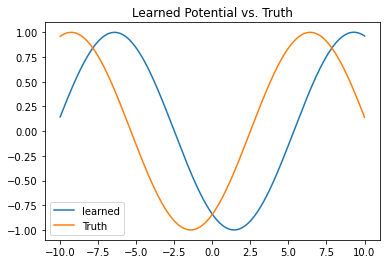

In [272]:
# print('Chebyshev Coefficients of the True Potential:', cvec, sep='\n')
# print('', 'Chebyshev Coefficients of the Learned Potential:', restrub, sep='\n')

print('Objective of the Learned Coefficients:', cobjfn(restrubadjgrad), sep='\n')
print('Vec L2 Norm of Gradient of the Learned Coefficients:', nl.norm(jaxgradcobjfn(restrubadjgrad)), sep='\n')

print('Continuous L2 Error of Potential using Quadrature Method:', np.sqrt(si.quad(sqrerrorfn, -L, L, args=(restrubadjgrad)))[0], sep='\n')

# plot learned vs true
plt.plot(xvec, ctoxmat @ restrubadjgrad, label='learned')
plt.plot(xvec, vxvec, label='Truth')
plt.title('Learned Potential vs. Truth')
plt.legend()
plt.show()

---

In [273]:
resformadjgrad = spo.minimize(jitcobjfn, cffform, jac=jitcgradfn, tol=1e-15, options={'maxiter': 1000, 'disp': True, 'gtol': 1e-14}).x

         Current function value: 0.000000
         Iterations: 122
         Function evaluations: 148
         Gradient evaluations: 142


Objective of the Learned Coefficients:
2.2011848584977247e-13
Vec L2 Norm of Gradient of the Learned Coefficients:
1.446328771776061e-12
Continuous L2 Error of Potential using Quadrature Method:
3.1990468073306637


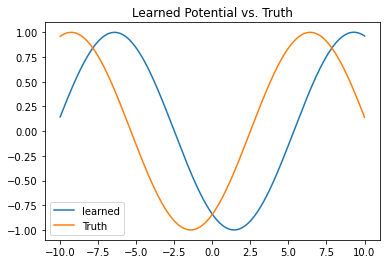

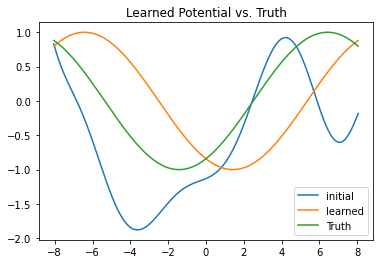

In [274]:
# print('Chebyshev Coefficients of the True Potential:', cvec, sep='\n')
# print('', 'Chebyshev Coefficients of the Learned Potential:', resform, sep='\n')

print('Objective of the Learned Coefficients:', cobjfn(resformadjgrad), sep='\n')
print('Vec L2 Norm of Gradient of the Learned Coefficients:', nl.norm(jaxgradcobjfn(resformadjgrad)), sep='\n')

print('Continuous L2 Error of Potential using Quadrature Method:', np.sqrt(si.quad(sqrerrorfn, -L, L, args=(resformadjgrad)))[0], sep='\n')

# plot learned vs true
# plt.plot(xvec, ctoxmat @ cfftrub, label='initial')
plt.plot(xvec, ctoxmat @ resformadjgrad, label='learned')
plt.plot(xvec, vxvec, label='Truth')
# plt.xlim((-5, 5))
# plt.ylim((0, 10))
plt.title('Learned Potential vs. Truth')
plt.legend()
plt.show()

# plot learned vs true
plt.plot(xvec[100:-100], (ctoxmat @ cfftrub)[100:-100], label='initial')
plt.plot(xvec[100:-100], (ctoxmat @ resformadjgrad)[100:-100], label='learned')
plt.plot(xvec[100:-100], vxvec[100:-100], label='Truth')
# plt.xlim((-5, 5))
# plt.ylim((0, 10))
plt.title('Learned Potential vs. Truth')
plt.legend()
plt.show()